In [2]:
!pip install tensorflow

In [5]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
import cv2 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
import warnings
warnings.filterwarnings('ignore')

In [5]:
data_dir = 'Xray/train'
filepaths = []
labels = []

slices = os.listdir(data_dir)
for slice in slices:
    slicepath = os.path.join(data_dir, slice)
    filelist = os.listdir(slicepath)
    for file in filelist:
        fpath = os.path.join(slicepath, file)
        filepaths.append(fpath)
        labels.append(slice)
        
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

In [6]:
df

,filepaths,labels
0,Xray/train\NORMAL\IM-0115-0001.jpeg,NORMAL
1,Xray/train\NORMAL\IM-0117-0001.jpeg,NORMAL
2,Xray/train\NORMAL\IM-0119-0001.jpeg,NORMAL
3,Xray/train\NORMAL\IM-0122-0001.jpeg,NORMAL
4,Xray/train\NORMAL\IM-0125-0001.jpeg,NORMAL
...,...,...
5211,Xray/train\PNEUMONIA\person99_virus_183.jpeg,PNEUMONIA
5212,Xray/train\PNEUMONIA\person9_bacteria_38.jpeg,PNEUMONIA
5213,Xray/train\PNEUMONIA\person9_bacteria_39.jpeg,PNEUMONIA
5214,Xray/train\PNEUMONIA\person9_bacteria_40.jpeg,PNEUMONIA


In [7]:
training_df, dum_df = train_test_split(df, train_size=0.8, shuffle= True, random_state = 123)
valid_df, test_df = train_test_split(dum_df, train_size= 0.6, shuffle=True, random_state=123)

In [8]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

test_length = len(test_df)
test_batch_size = max(sorted([test_length // n for n in range(1, test_length + 1) if test_length%n == 0 and test_length/n <= 80]))
test_steps = test_length // test_batch_size

def ImageScalar(img):
    return img
tr_gen = ImageDataGenerator(preprocessing_function= ImageScalar)
ts_gen = ImageDataGenerator(preprocessing_function= ImageScalar)

train_gen = tr_gen.flow_from_dataframe( training_df, x_col='filepaths', y_col= 'labels', target_size = img_size, class_mode= 'categorical',
                                      color_mode='rgb', shuffle= True, batch_size = batch_size)
valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col='filepaths', y_col= 'labels', target_size = img_size, class_mode= 'categorical',
                                      color_mode='rgb', shuffle= True, batch_size = batch_size)
test_gen = ts_gen.flow_from_dataframe( test_df, x_col='filepaths', y_col= 'labels', target_size = img_size, class_mode= 'categorical',
                                      color_mode='rgb', shuffle= False, batch_size = test_batch_size)

Found 4172 validated image filenames belonging to 2 classes.
Found 626 validated image filenames belonging to 2 classes.
Found 418 validated image filenames belonging to 2 classes.


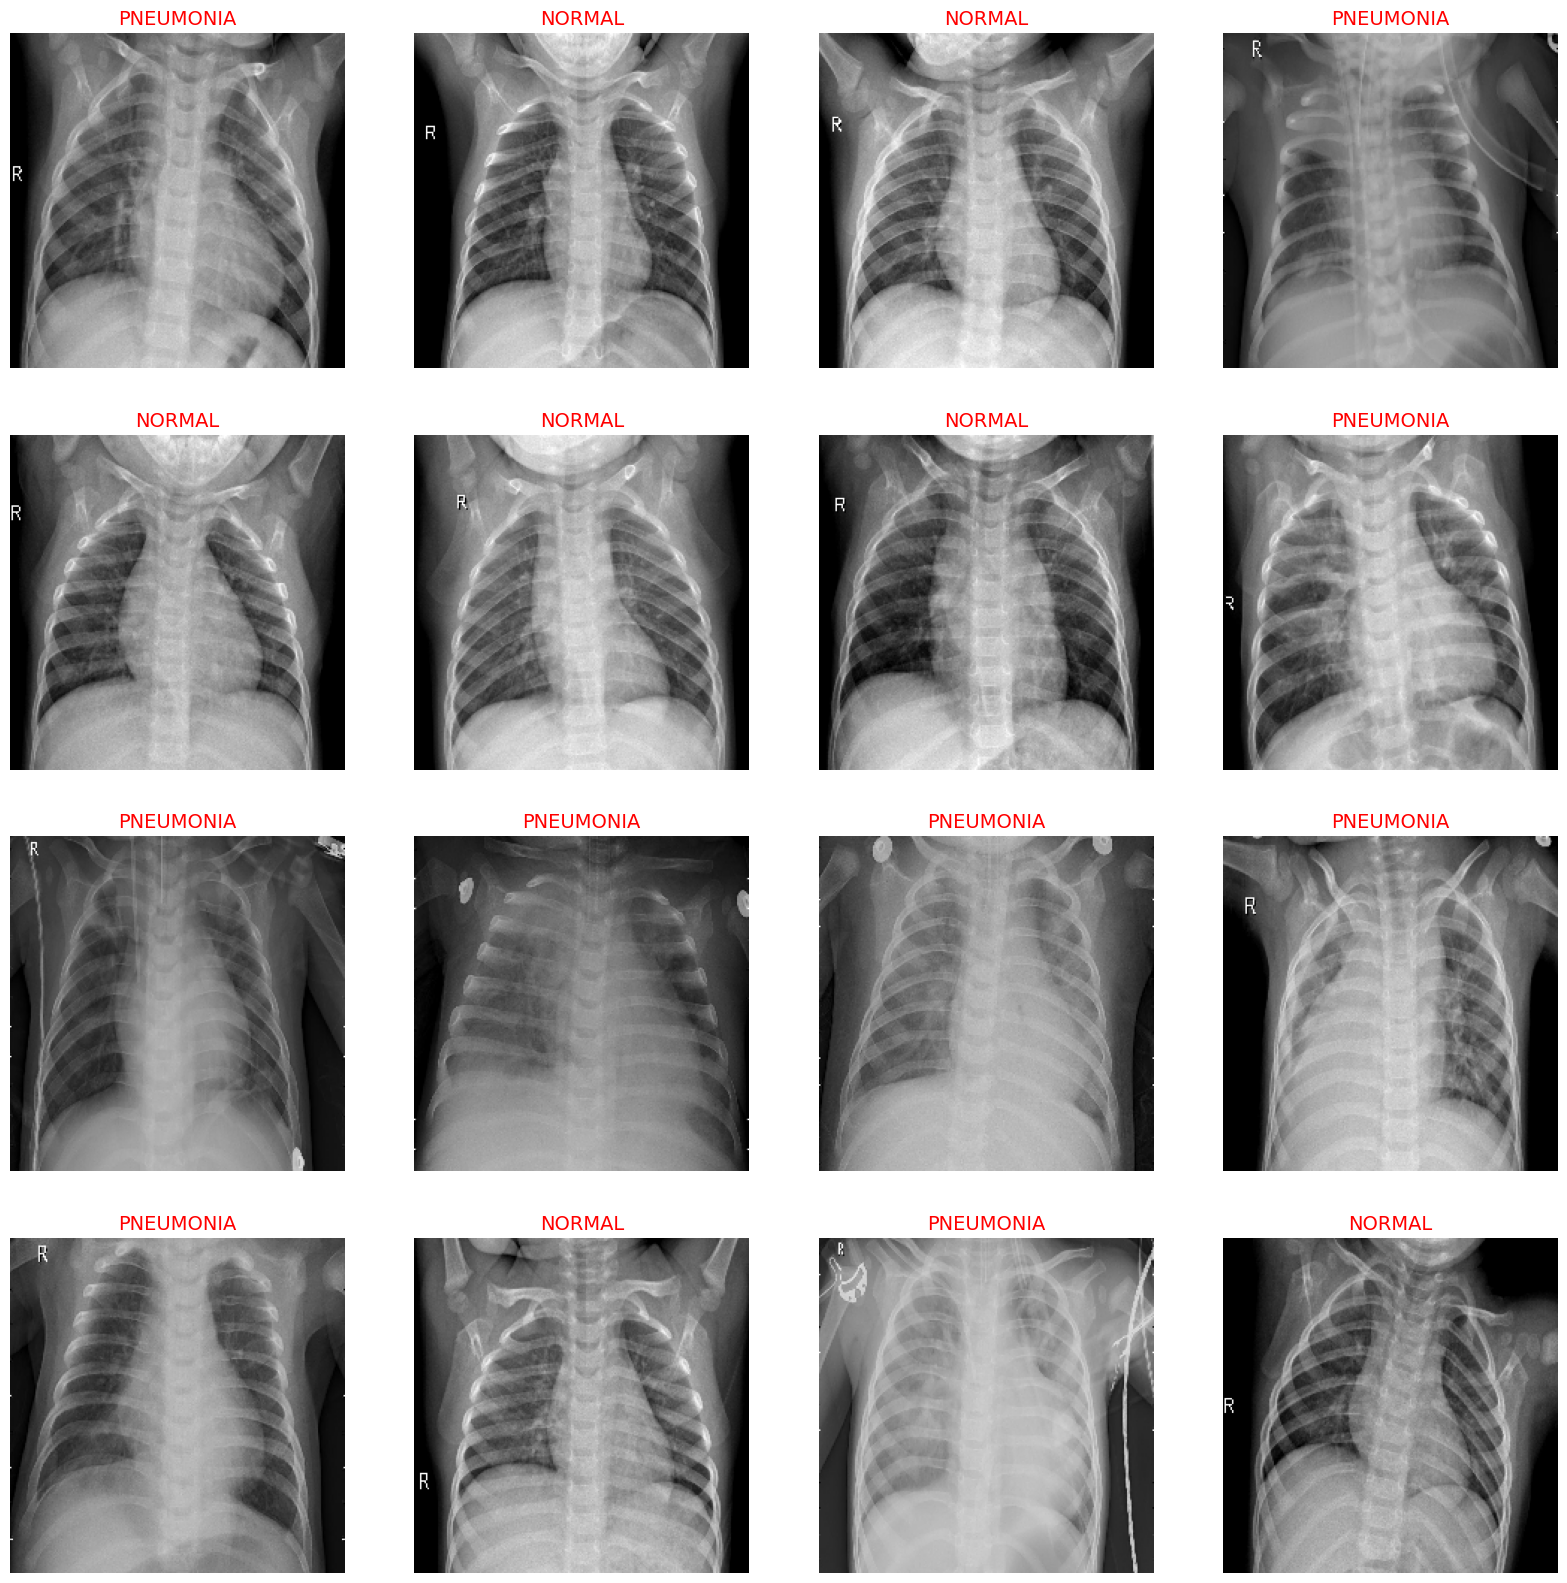

In [9]:
gen_dict= train_gen.class_indices
classes= list(gen_dict.keys())

images, labels = next(train_gen)

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name= classes[index]
    plt.title(class_name, color='red', fontsize= 14)
    plt.axis('off')

In [10]:
img_size = (224, 224)
channels = 3
image_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

my_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights= 'imagenet', input_shape = image_shape, pooling= 'max')

model = Sequential([
    my_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006), activation='relu'), Dropout(rate= 0.45, seed= 123), 
        Dense(class_count, activation='softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 4383141 (16.72 MB)
Trainable params: 43385

In [12]:
batch_size = 16
epochs = 10
history = model.fit(x= train_gen, epochs = epochs, verbose= 1, validation_data= valid_gen,
                   validation_steps= None, shuffle= False)

Epoch 1/10
261/261 [==============================] - 593s 2s/step - loss: 5.1203 - accuracy: 0.9233 - val_loss: 3.5364 - val_accuracy: 0.8770
Epoch 2/10
261/261 [==============================] - 551s 2s/step - loss: 2.6385 - accuracy: 0.9691 - val_loss: 2.0794 - val_accuracy: 0.9297
Epoch 3/10
261/261 [==============================] - 553s 2s/step - loss: 1.6167 - accuracy: 0.9782 - val_loss: 1.2625 - val_accuracy: 0.9952
Epoch 4/10
261/261 [==============================] - 552s 2s/step - loss: 1.0505 - accuracy: 0.9849 - val_loss: 0.8188 - val_accuracy: 0.9952
Epoch 5/10
261/261 [==============================] - 549s 2s/step - loss: 0.6986 - accuracy: 0.9875 - val_loss: 0.5521 - val_accuracy: 0.9984
Epoch 6/10
261/261 [==============================] - 550s 2s/step - loss: 0.4618 - accuracy: 0.9947 - val_loss: 0.3951 - val_accuracy: 0.9824
Epoch 7/10
261/261 [==============================] - 548s 2s/step - loss: 0.3334 - accuracy: 0.9926 - val_loss: 0.2595 - val_accuracy: 0.9952

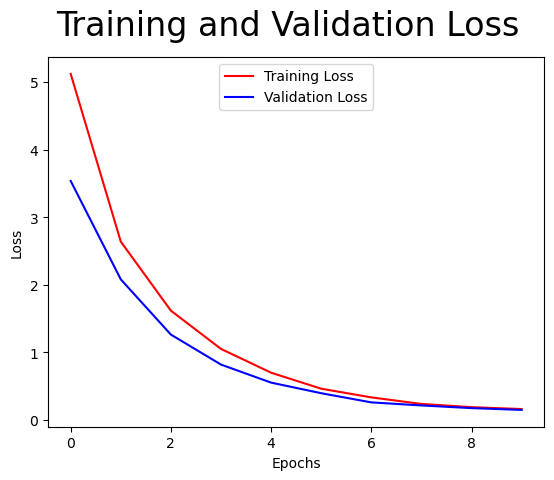

In [13]:
figure = plt.figure()
plt.plot(history.history['loss'], color='red', label='Training Loss')
plt.plot(history.history['val_loss'], color='blue', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
figure.suptitle('Training and Validation Loss', fontsize=24)
plt.legend(loc="upper center")
plt.show()

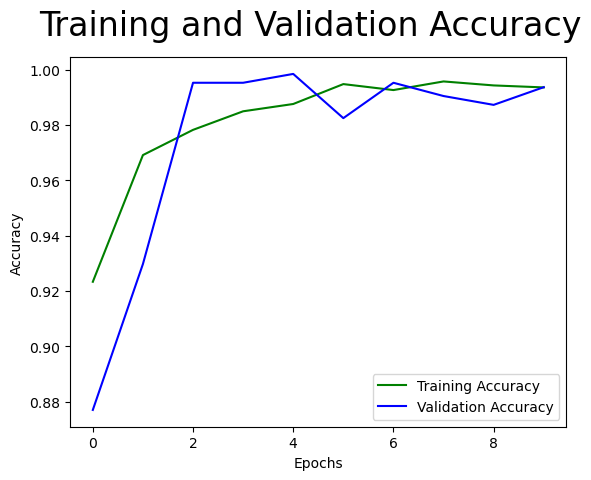

In [14]:
figure2 = plt.figure()
plt.plot(history.history['accuracy'], color='green', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='blue', label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
figure2.suptitle('Training and Validation Accuracy', fontsize=24)
plt.legend(loc="lower right")
plt.show()

In [15]:
predictions = model.predict_generator(test_gen)
y_pred = np.argmax(predictions, axis=1)


Confusion matrix, without normalization
[[100   5]
 [  4 309]]
Normalized confusion matrix
[[0.95 0.05]
 [0.01 0.99]]


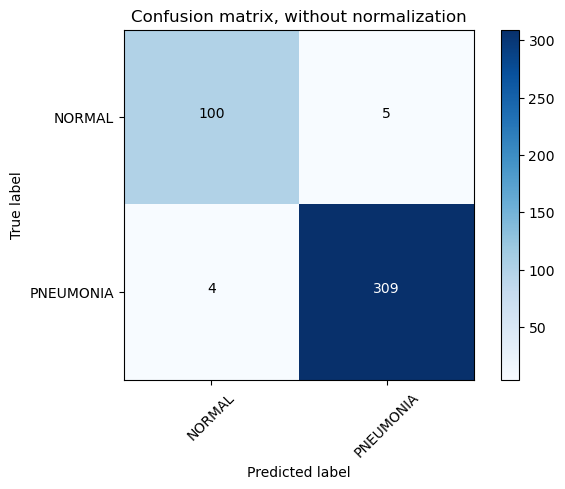

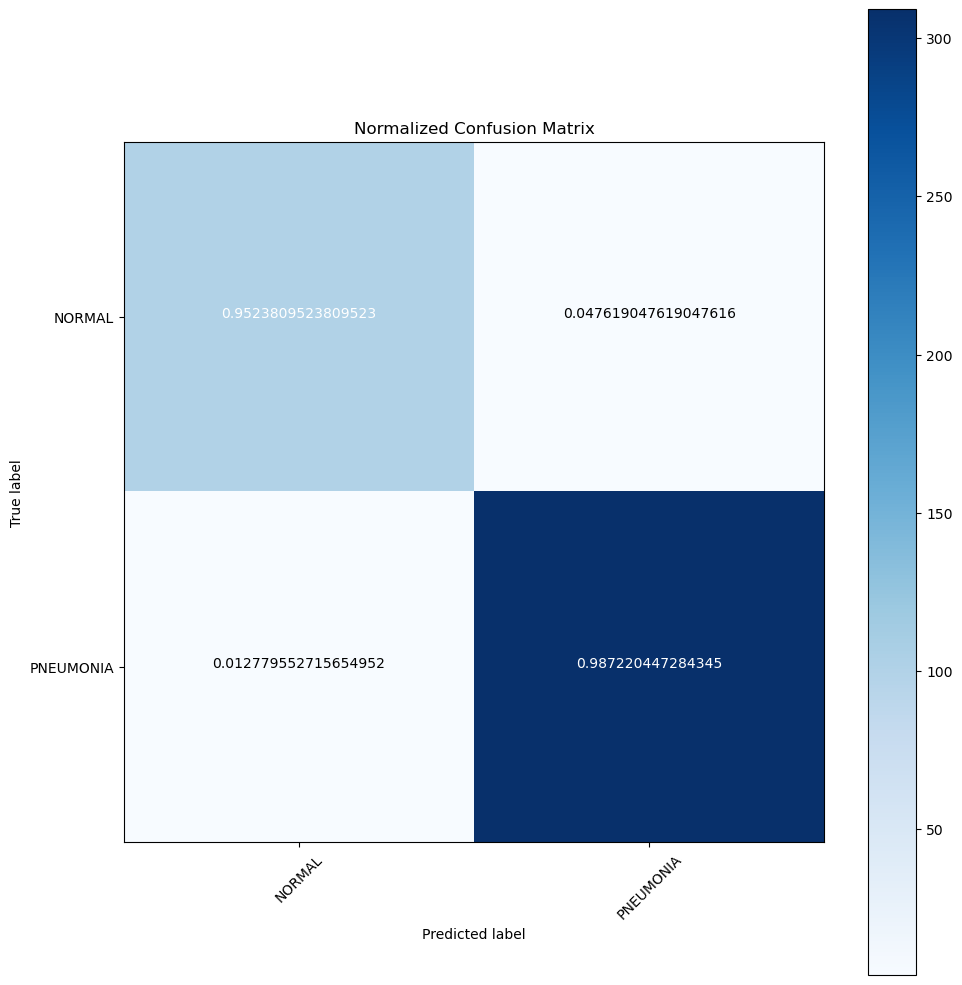

In [16]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

gen_dict = test_gen.class_indices
classes = list(gen_dict.keys())



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_gen.classes, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['NORMAL', 'PNEUMONIA'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=['NORMAL', 'PNEUMONIA'], normalize=True,
                      title='Normalized Confusion Matrix')

plt.show()

In [17]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      NORMAL       0.96      0.95      0.96       105
   PNEUMONIA       0.98      0.99      0.99       313

    accuracy                           0.98       418
   macro avg       0.97      0.97      0.97       418
weighted avg       0.98      0.98      0.98       418



In [18]:
model.save('CXR_Reader.h5')

In [6]:
loaded_model= tf.keras.models.load_model('CXR_Reader.h5', compile=False)
loaded_model.compile(Adamax(learning_rate=0.001), loss='binary_crossentropy', metrics= ['accuracy'])

In [ ]:
user_image = input('Enter file path to image')

In [ ]:
img_path = user_image
image = Image.open(img_path)
img = image.resize((224, 224))

img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

preds = loaded_model.predict(img_array)
final_pred = tf.argmax(preds, axis = 1)
class_labels=['Normal', 'Pneumonia']
score = tf.nn.softmax(preds[0])


if score[0] >= 0.29:
    print("This image depicts normal lungs")
else:
    print("This image depicts pneumonia in the lungs")

plt.imshow(img)

    

1/1 [==============================] - 2s 2s/step


<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.27, 0.73], dtype=float32)>

0.0017209877